In [1]:
import os
import json
import torch
import random
import cv2
import math
import numpy as np
import torchvision
from pathlib import Path
from torch import nn
from torch import optim
import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.nn import functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt 
import matplotlib
import tqdm
from PIL import Image
from module import *
from model import *
from dataset import *
from metric import *

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tau = 3

In [55]:
YTB_dataset = YouTubeVOS_Data()
train_size = int(0.8  * len(YTB_dataset))
valid_size = len(YTB_dataset) - train_size
train_dataset, valid_dataset = Data.random_split(YTB_dataset, [train_size, valid_size])
train_size = int(0.1*len(train_dataset))
valid_size = int(0.1*len(valid_dataset))
sampler_train = Data.sampler.SubsetRandomSampler(np.random.choice(range(len(train_dataset)), train_size))
sampler_valid = Data.sampler.SubsetRandomSampler(np.random.choice(range(len(valid_dataset)), valid_size))
train_dataloader = Data.DataLoader(train_dataset, batch_size=1, sampler=sampler_train)
valid_dataloader = Data.DataLoader(valid_dataset, batch_size=1, sampler=sampler_valid)
print(len(train_dataloader), len(valid_dataloader))

277 69


In [3]:
def train(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs):
    
    LOSS_train = []
    LOSS_valid = []
    Jaccard_train = []
    Jaccard_valid = []  
    Dice_train = []
    Dice_valid = []

    for epoch in tqdm.trange(epochs, desc="Epochs"):
        result = []
        train_loss = 0.0
        train_Jaccard = 0.0
        train_dice = 0.0
        valid_loss = 0.0
        valid_Jaccard = 0.0
        valid_dice = 0.0
        count_train = 0
        count_valid = 0 

        # Begin training
        model.train()
        for datapack in train_dataloader:
            data, mask, temp, num_objs = datapack['Frames'].to(device), datapack['Masks'].to(device), datapack['Preds'].to(device), int(datapack['Num_objs'])
            T = data.shape[1]
            _, _, H, W = mask.shape
            num_cls = num_objs + 1
            for frame_idx in range(1, T):
                if frame_idx < tau:
                    x = data[:,0:frame_idx+1,:,:,:]
                    m = temp[:,0:frame_idx+1,:,:]
                    # gt = mask[:,0:frame_idx+1,:,:]
                    gt = mask[:,frame_idx,:,:].long()
                else:
                    x = data[:,frame_idx+1-tau:frame_idx+1,:,:,:]
                    m = temp[:,frame_idx+1-tau:frame_idx+1,:,:]
                    # gt = mask[:,frame_idx+1-tau:frame_idx+1,:,:]
                    gt = mask[:,frame_idx,:,:].long()
                output, preds = model(x, m, num_cls)
                output = F.interpolate(output[:,-1,:,:,:],size=[H,W],mode='bilinear',align_corners=True)
                preds = preds[:,-1,:,:]
                temp[0][frame_idx] = preds                                  # Update prediction to temp
                loss = criterion(output, gt)
                loss.backward()                                 # Compute gradients
                optimizer.step()                                # Update the model parameters
                optimizer.zero_grad()
                preds = F.interpolate(preds.float().unsqueeze(0),size=[H,W],mode='nearest').squeeze(0)
                train_loss += loss.item()        # Compute training loss
                train_Jaccard += get_Jaccard(gt, preds)
                train_dice += get_Dice(gt, preds)
                count_train += 1
        torch.save(model,"C:/Users/Siyao/Downloads/YOUTUBE-VOS/models/1116_ytb.pt")
        

        # Begin validation
        model.eval()
        for datapack in valid_dataloader:
            data, mask, temp, num_objs = datapack['Frames'].to(device), datapack['Masks'].to(device), datapack['Preds'].to(device), int(datapack['Num_objs'])
            T = data.shape[1]
            _, _, H, W = mask.shape
            num_cls = num_objs + 1
            for frame_idx in range(1, T):
                if frame_idx < tau:
                    x = data[:,0:frame_idx+1,:,:,:]
                    m = temp[:,0:frame_idx+1,:,:]
                    # gt = mask[:,0:frame_idx+1,:,:]
                    gt = mask[:,frame_idx,:,:].long()
                else:
                    x = data[:,frame_idx+1-tau:frame_idx+1,:,:,:]
                    m = temp[:,frame_idx+1-tau:frame_idx+1,:,:]
                    # gt = mask[:,frame_idx+1-tau:frame_idx+1,:,:]
                    gt = mask[:,frame_idx,:,:].long()
                output, preds = model(x, m, num_cls)
                output = F.interpolate(output[:,-1,:,:,:],size=[H,W],mode='bilinear',align_corners=True)
                preds = preds[:,-1,:,:]
                temp[0][frame_idx] = preds                                  # Update prediction to temp
                loss = criterion(output, gt)
                preds = F.interpolate(preds.float().unsqueeze(0),size=[H,W],mode='nearest').squeeze(0)
                valid_loss += loss.item()      # Compute training loss
                valid_Jaccard += get_Jaccard(gt, preds)
                valid_dice += get_Dice(gt, preds)
                count_valid += 1

        torch.save(model,"C:/Users/Siyao/Downloads/YOUTUBE-VOS/models/1116_ytb.pt")
        # Compute epoch loss and f1
        epoch_train_loss = train_loss / count_train
        epoch_train_Jaccard = train_Jaccard / count_train
        epoch_train_dice = train_dice / count_train
        epoch_valid_loss = valid_loss / count_valid
        epoch_valid_Jaccard = valid_Jaccard / count_valid
        epoch_valid_dice = valid_dice / count_valid

        # Record epoch loss and f1 to the list
        LOSS_train.append(epoch_train_loss)
        LOSS_valid.append(epoch_valid_loss)
        Jaccard_train.append(epoch_train_Jaccard)
        Jaccard_valid.append(epoch_valid_Jaccard)   
        Dice_train.append(epoch_train_dice)
        Dice_valid.append(epoch_valid_dice)

        result.append(f'{epoch} TRAIN loss: {epoch_train_loss:.4f}, Jaccard: {epoch_train_Jaccard:.4f}, Dice: {epoch_train_dice:.4f};  VALID loss: {epoch_valid_loss:.4f}, Jaccard: {epoch_valid_Jaccard:.4f}, Dice: {epoch_valid_dice:.4f}')
        print(result)

    return LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid

In [56]:
model = MyTransformer()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
LOSS_train, LOSS_valid, Jaccard_train, Jaccard_valid, Dice_train, Dice_valid = train(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs=10)

Epochs:  10%|█         | 1/10 [26:45<4:00:45, 1605.03s/it]

['0 TRAIN loss: 2.5376, Jaccard: 0.3513, Dice: 0.5444;  VALID loss: 2.6069, Jaccard: 0.1879, Dice: 0.3246']


Epochs:  20%|██        | 2/10 [53:55<3:36:00, 1620.02s/it]

['1 TRAIN loss: 2.5048, Jaccard: 0.3890, Dice: 0.5827;  VALID loss: 2.5891, Jaccard: 0.2323, Dice: 0.3966']


Epochs:  30%|███       | 3/10 [1:20:25<3:07:23, 1606.28s/it]

['2 TRAIN loss: 2.3863, Jaccard: 0.5558, Dice: 0.7707;  VALID loss: 2.6024, Jaccard: 0.2538, Dice: 0.4152']


Epochs:  40%|████      | 4/10 [1:47:31<2:41:24, 1614.16s/it]

['3 TRAIN loss: 2.3158, Jaccard: 0.6318, Dice: 0.8508;  VALID loss: 2.6040, Jaccard: 0.2364, Dice: 0.4015']


Epochs:  50%|█████     | 5/10 [2:13:50<2:13:27, 1601.52s/it]

['4 TRAIN loss: 2.2682, Jaccard: 0.6836, Dice: 0.9015;  VALID loss: 2.6110, Jaccard: 0.2346, Dice: 0.3973']


Epochs:  60%|██████    | 6/10 [2:41:28<1:48:02, 1620.63s/it]

['5 TRAIN loss: 2.2126, Jaccard: 0.7319, Dice: 0.9499;  VALID loss: 2.5991, Jaccard: 0.2347, Dice: 0.4003']


Epochs:  70%|███████   | 7/10 [3:09:37<1:22:09, 1643.07s/it]

['6 TRAIN loss: 2.1862, Jaccard: 0.7640, Dice: 0.9813;  VALID loss: 2.6019, Jaccard: 0.2352, Dice: 0.4020']


Epochs:  80%|████████  | 8/10 [3:37:40<55:11, 1655.72s/it]  

['7 TRAIN loss: 2.1844, Jaccard: 0.7857, Dice: 1.0015;  VALID loss: 2.5998, Jaccard: 0.2339, Dice: 0.4011']


Epochs:  90%|█████████ | 9/10 [4:04:13<27:15, 1635.99s/it]

['8 TRAIN loss: 2.1853, Jaccard: 0.8103, Dice: 1.0216;  VALID loss: 2.6003, Jaccard: 0.2348, Dice: 0.4025']


Epochs: 100%|██████████| 10/10 [4:30:34<00:00, 1623.47s/it]

['9 TRAIN loss: 2.2124, Jaccard: 0.7858, Dice: 1.0010;  VALID loss: 2.6015, Jaccard: 0.2327, Dice: 0.4002']


In [119]:
def get_pred(model, datapack):
    model.eval()
    data, mask, temp, num_objs = datapack['Frames'].to(device), datapack['Masks'].to(device), datapack['Preds'].to(device), int(datapack['Num_objs'])
    # data = data.unsqueeze(0)
    # mask = mask.unsqueeze(0)
    # temp = temp.unsqueeze(0)
    T = data.shape[1]
    _, _, H, W = mask.shape
    num_cls = num_objs + 1
    loss_list = []
    jaccard_list = []
    dice_list = []
    for frame_idx in range(1, 2):
        if frame_idx < tau:
            x = data[:,0:frame_idx+1,:,:,:]
            m = temp[:,0:frame_idx+1,:,:]
            # gt = mask[:,0:frame_idx+1,:,:]
            gt = mask[:,frame_idx,:,:].long()
        else:
            x = data[:,frame_idx+1-tau:frame_idx+1,:,:,:]
            m = temp[:,frame_idx+1-tau:frame_idx+1,:,:]
            # gt = mask[:,frame_idx+1-tau:frame_idx+1,:,:]
            gt = mask[:,frame_idx,:,:].long()
        output, preds = model(x, m, num_cls)
        output = F.interpolate(output[:,-1,:,:,:],size=[H,W],mode='bilinear',align_corners=True)
        preds = preds[:,-1,:,:]
        temp[0][frame_idx] = preds                                  # Update prediction to temp
        loss = criterion(output, gt)
        preds = F.interpolate(preds.float().unsqueeze(0),size=[H,W],mode='nearest').squeeze(0)
        loss_list.append(loss.item())      # Compute training loss
        jaccard_list.append(get_Jaccard(gt, preds))
        dice_list.append(get_Dice(gt, preds))
    print(f"Loss:{np.mean(loss_list)}; Jaccard:{np.mean(jaccard_list)}, Dice:{np.mean(dice_list)}")
    return temp

In [112]:
len(train_dataloader)

277

Data shape: torch.Size([36, 3, 256, 448])
Mask shape: torch.Size([36, 720, 1280])
Pred shape: torch.Size([36, 256, 448])
Num of Objects: 1


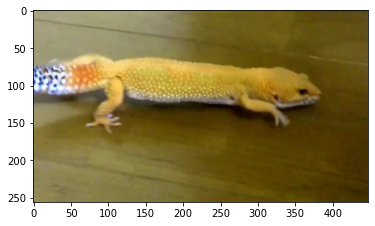

In [126]:
package = train_dataset[100]
a = package['Frames']
b = package['Masks']
b0 = package['Preds']
c = package['Num_objs']
print(f"Data shape: {a.shape}")
print(f"Mask shape: {b.shape}")
print(f"Pred shape: {b0.shape}")
print(f"Num of Objects: {int(c)}")
img = a[0].permute(1,2,0)
plt.imshow(img)

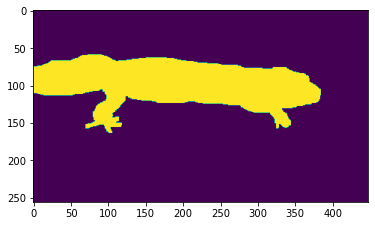

In [130]:
plt.imshow(b0[0])

Loss:0.6935700178146362; Jaccard:0.19160260260105133, Dice:0.32158806920051575


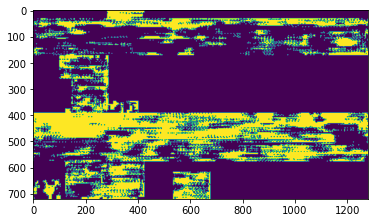

In [122]:
datapack = next(iter(valid_dataloader))
prediction = get_pred(model, datapack)

In [87]:
prediction[0].shape

torch.Size([1, 720, 1280])

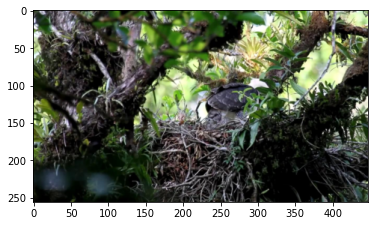

In [102]:
plt.imshow(datapack['Frames'][0][2].permute(1,2,0))

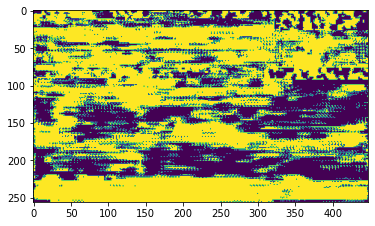

In [106]:
plt.imshow(prediction[0][4].detach().cpu())